# Project path planing


In [143]:
!pip install --upgrade tdmclient
!pip install ipython
!pip install shapely
!pip install networkx


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Includes

In [144]:
# Importing libraries
from PIL import Image
from IPython.display import Image, display
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt 
from shapely.geometry import LineString
from shapely.geometry import Point
from itertools import combinations
import networkx as nx
from shapely.geometry import LineString


## Imoprting and scaling image

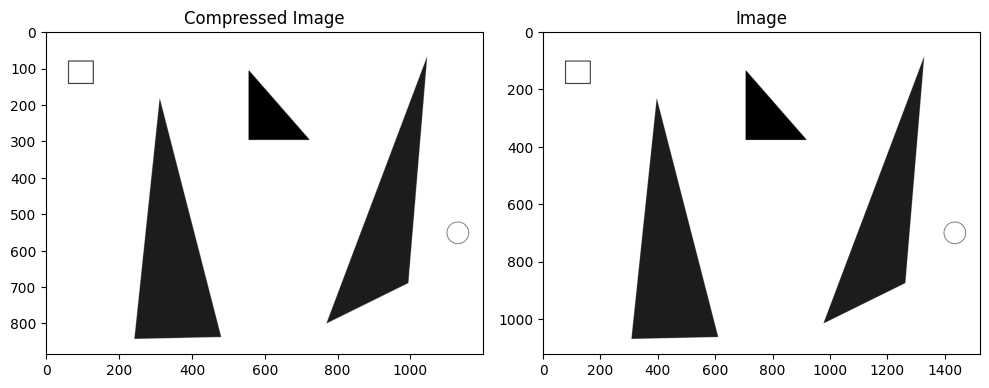

In [135]:
# Load the image
#filename = 'visibility.png'
filename = 'visibility_bis.png'

img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# Define the desired dimensions
new_width = 1200
new_height = 1000

# Define a kernel for dilation
kernel = np.ones((3, 3), np.uint8)


# Calculate the scaling factor to maintain aspect ratio
width, height = img.shape[1], img.shape[0]
aspect_ratio = width / height

if width / new_width > height / new_height:
    new_height = int(new_width / aspect_ratio)
else:
    new_width = int(new_height * aspect_ratio)

# Resize the image while preserving the aspect ratio
compressed_img = cv2.resize(img, (new_width, new_height))
comp_height, comp_width = compressed_img.shape

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[0].imshow(compressed_img, cmap='gray')
axes[0].set_title('Compressed Image')
axes[0].axis('on')

# Display the second image (other_image)
axes[1].imshow(img, cmap='gray')
axes[1].set_title('Image')
axes[1].axis('on')

plt.tight_layout()
plt.show()

## Filtering and enhancing edges

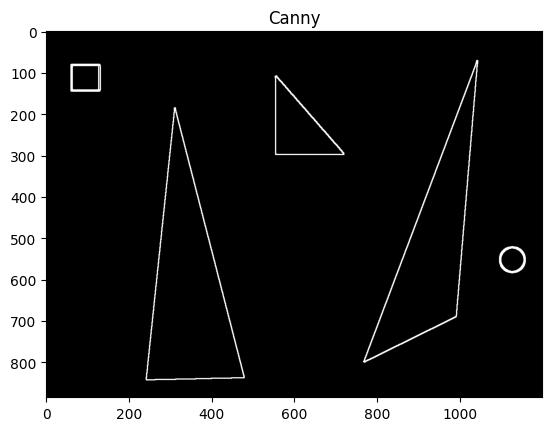

In [136]:
lower_threshold = 100
upper_threshold = 150
aperture_size = 7 # Increase if want more details

canny_img = cv2.Canny(compressed_img, lower_threshold, upper_threshold, apertureSize=aperture_size, L2gradient = True)
# Apply dilation to make edges thicker
dilated_edges = cv2.dilate(canny_img, kernel, iterations=1)

# Save the enhanced edges image
plt.imshow(dilated_edges, cmap='gray');
plt.title('Canny'); plt.axis('on');

## Using contour for detecting the edges of the vertices

In [137]:
triangle_vertices = []
triangle_edges = []

(contours, _) = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def detectShape(c):          #Function to determine type of polygon on basis of number of sides
       shape = 'unknown' 
       peri=cv2.arcLength(cnt,True) 
       vertices = cv2.approxPolyDP(cnt, 0.02 * peri, True)
       sides = len(vertices) 
       if (sides == 3): 
            shape='triangle' 
       elif(sides==4): 
             x,y,w,h=cv2.boundingRect(cnt)
             aspectratio=float(w)/h 
             if (aspectratio==1):
                   shape='square'
             else:
                   shape="rectangle" 
       elif(sides==5):
            shape='pentagon' 
       elif(sides==6):
            shape='hexagon' 
       elif(sides==8): 
            shape='octagon' 
       elif(sides==10): 
            shape='star'
       else:
           shape='circle' 
       return shape 

for cnt in contours:
    shape = detectShape(cnt)
    print('shape', shape)
    if shape == 'triangle':
        vertices = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        triangle = []  # Store vertices for each triangle
        edges = []  # Store lines for each triangle
        
        for i, vertex in enumerate(vertices):
            x, y = vertex[0]
            triangle.append((x, y))

            next_index = 0 if i == len(vertices) - 1 else i + 1
            next_vertex = vertices[next_index][0]
            cv2.circle(canny_img, (x, y), 5, (255, 0, 0), -1)  
            cv2.putText(canny_img, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0,  0), 2)
                                                                                         
            # Append edges/lines
            edges.append(((x, y), (next_vertex[0], next_vertex[1])))

        triangle_vertices.append(triangle)  # Append the vertices to the list
        triangle_edges.append(edges)  # Append the edges to the list
    # This will be our final goal    
    elif shape == 'octagon':
        # Store circle information
        (Xcent,Ycent), radius = cv2.minEnclosingCircle(cnt)
        (Xcent,Ycent)= (int(Xcent),int(Ycent))
        radius = int(radius)
    # This will be the initial position of the robot starting top left corner   
    elif shape == 'rectangle':
        Xrob,Yrob,Wrob,Hrob=cv2.boundingRect(cnt)
        # Calculate the center of the rectangle
        Xrob_center = Xrob + Wrob // 2
        Yrob_center = Yrob + Hrob // 2
    
    
print((Xcent,Ycent))
print((Xrob_center,Yrob_center))



shape octagon
shape triangle
shape triangle
shape rectangle
shape triangle
(1127, 552)
(96, 113)


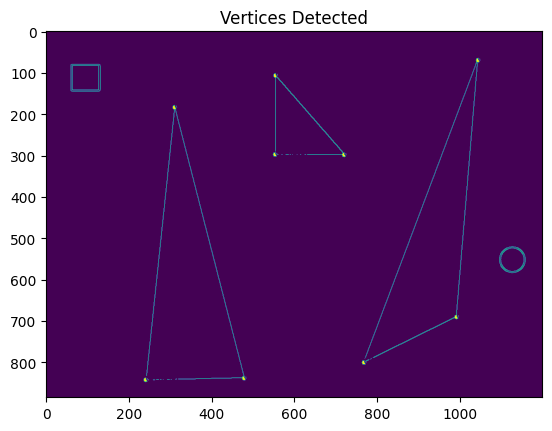

[[(311, 184), (241, 843), (479, 839)], [(555, 107), (554, 298), (721, 299)], [(1045, 70), (769, 801), (993, 691)]]


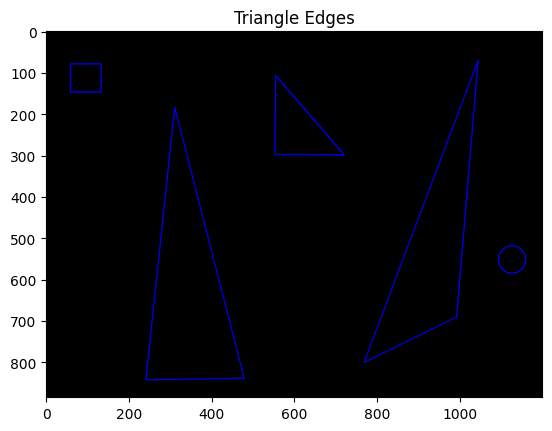

[[((311, 184), (241, 843)), ((241, 843), (479, 839)), ((479, 839), (311, 184))], [((555, 107), (554, 298)), ((554, 298), (721, 299)), ((721, 299), (555, 107))], [((1045, 70), (769, 801)), ((769, 801), (993, 691)), ((993, 691), (1045, 70))]]


In [144]:
# Display the initial image with highlighted vertices
plt.imshow(canny_img)
plt.title('Vertices Detected')
plt.show()
print(triangle_vertices)


# Create a blank image
blank_img = np.zeros((comp_height, comp_width, 3), np.uint8)

# Plot the lines for each triangle
for edges in triangle_edges:
    for edge in edges:
        cv2.line(blank_img, edge[0], edge[1], (0, 0, 255), 2)

# Draw the final position
cv2.circle(blank_img, (Xcent, Ycent), int(radius), (0, 0, 255), 2)


# Draw the robot position
cv2.rectangle(blank_img, (Xrob, Yrob), (Xrob + Wrob, Yrob + Hrob), (0, 0, 255), 2)

plt.imshow(blank_img)
plt.title('Triangle Edges')
plt.axis('on')
plt.show()
print(triangle_edges)

## Adjancy graph

In [146]:
def check_intersection(vertex1, vertex2, triangle1_edges, triangle2_edges):
    line = LineString([vertex1, vertex2])
#    print('line1', line)
    for edge in triangle1_edges:
        for i in range(len(edge)):
            if i != len(edge) - 1:
                edge1 = LineString([edge[i], edge[i + 1]])
            else:
                edge1 = LineString([edge[i], edge[0]])

            if (line.coords[0] in edge1.coords) or (line.coords[1] in edge1.coords):
#                print('The line shares a common point with triangle 1 edge:', edge1)
                break  # Disregard connection if the same vertex is part of both lines

            elif line.intersects(edge1):
#                print('Intersection found with triangle 1 edge:', edge1)
                return True  # If an intersection is detected, return True

    for edge in triangle2_edges:
        for i in range(len(edge)):
            if i != len(edge) - 1:
                edge2 = LineString([edge[i], edge[i + 1]])
            else:
                edge2 = LineString([edge[i], edge[0]])

            if (line.coords[0] in edge2.coords) or (line.coords[1] in edge2.coords):
#                print('The line shares a common point with triangle 2 edge:', edge2)
                break  # Disregard connection if the same vertex is part of both lines

            elif line.intersects(edge2):
#                print('Intersection found with triangle 2 edge:', edge2)
                return True  # If an intersection is detected, return True

    return False

# DEBUG


In [265]:
def TEST_check_intersection2(vertex1, vertex2, triangle_edges):
    line = LineString([vertex1, vertex2])
#    print('line1', line)
    j = 0
    for edge_set in triangle_edges:
        print("j =", j)
        print(edge_set)
        for i in range(len(edge_set)):
            print("i = ", i)
            print(edge_set[i][0], edge_set[i][1])
            edge1 = LineString([edge_set[i][0], edge_set[i][1]])
            print((edge1))

            if (line.coords[0] in edge1.coords) or (line.coords[1] in edge1.coords):
                print('The line shares a common point with triangle 1 edge:', edge1)
                break  # Disregard connection if the same vertex is part of both lines

            if line.intersects(edge1):
                print('Intersection found with triangle 1 edge:', edge1)
                return True  # If an intersection is detected, return True

    return False

In [262]:
# Assuming triangle_vertices contains vertex information for each triangle and triangle_edges contains the edges
G = nx.Graph()
G.clear()
for i, triangle1 in enumerate(triangle_vertices):
    for j, triangle2 in enumerate(triangle_vertices):
        if i != j:  # Ensure you're comparing vertices from different triangles
            for vertex1 in triangle1:
                for vertex2 in triangle2:
                    if vertex1 != vertex2:
                        intersection = TEST_check_intersection2(vertex1, vertex2, triangle_edges)
#                        print('intersection is',intersection)
                        if not intersection:  # If no intersection add to the edge if intersection = false add
                            print('not intersect the path is valid between V1 and V2')
                            print('number of edges is', G.number_of_edges())
                            # check if graph has an edge going in same direction
                            #if G.edges() 
                            G.add_edge(vertex1, vertex2)  # Add edge to the graph
                        # Hanfling the initial position and the goal of the robot
                        #circle_intersect_v1 = TEST_check_intersection2(vertex1, (Xcent,Ycent), triangle_edges)
                        #circle_intersect_v2 = TEST_check_intersection2(vertex2, (Xcent,Ycent), triangle_edges)
                        #robot_intersect_v1 = TEST_check_intersection2(vertex1, (Xrob_center,Yrob_center), triangle_edges)
                        #robot_intersect_v2 = TEST_check_intersection2(vertex2, (Xrob_center,Yrob_center), triangle_edges)
                
#                         if not circle_intersect_v1:
#                             G.add_edge(vertex1, (Xcent,Ycent))
#                         if not circle_intersect_v2:
#                             G.add_edge(vertex2, (Xcent,Ycent))
#                         if not robot_intersect_v1:
#                             G.add_edge(vertex1, (Xrob_center, Yrob_center))
#                         if not robot_intersect_v2:
#                             G.add_edge(vertex2, (Xrob_center, Yrob_center))
                    
# Iterate through each triangle
# for i, triangle_edge in enumerate(triangle_edges):
#     for edge in triangle_edge:
#         G.add_edge(edge[0], edge[1])  # Add each edge to the graph


j = 0
[((311, 184), (241, 843)), ((241, 843), (479, 839)), ((479, 839), (311, 184))]
i =  0
(311, 184) (241, 843)
LINESTRING (311 184, 241 843)
The line shares a common point with triangle 1 edge: LINESTRING (311 184, 241 843)
j = 0
[((555, 107), (554, 298)), ((554, 298), (721, 299)), ((721, 299), (555, 107))]
i =  0
(555, 107) (554, 298)
LINESTRING (555 107, 554 298)
The line shares a common point with triangle 1 edge: LINESTRING (555 107, 554 298)
j = 0
[((1045, 70), (769, 801)), ((769, 801), (993, 691)), ((993, 691), (1045, 70))]
i =  0
(1045, 70) (769, 801)
LINESTRING (1045 70, 769 801)
i =  1
(769, 801) (993, 691)
LINESTRING (769 801, 993 691)
i =  2
(993, 691) (1045, 70)
LINESTRING (993 691, 1045 70)
not intersect the path is valid between V1 and V2
number of edges is 0
j = 0
[((311, 184), (241, 843)), ((241, 843), (479, 839)), ((479, 839), (311, 184))]
i =  0
(311, 184) (241, 843)
LINESTRING (311 184, 241 843)
The line shares a common point with triangle 1 edge: LINESTRING (311 

In [263]:
G.edges()

EdgeView([((311, 184), (555, 107)), ((311, 184), (554, 298)), ((311, 184), (769, 801)), ((555, 107), (241, 843)), ((555, 107), (479, 839)), ((555, 107), (1045, 70)), ((555, 107), (769, 801)), ((554, 298), (241, 843)), ((554, 298), (479, 839)), ((554, 298), (1045, 70)), ((554, 298), (769, 801)), ((241, 843), (721, 299)), ((241, 843), (1045, 70)), ((241, 843), (769, 801)), ((721, 299), (479, 839)), ((721, 299), (1045, 70)), ((721, 299), (769, 801)), ((479, 839), (1045, 70)), ((479, 839), (769, 801))])

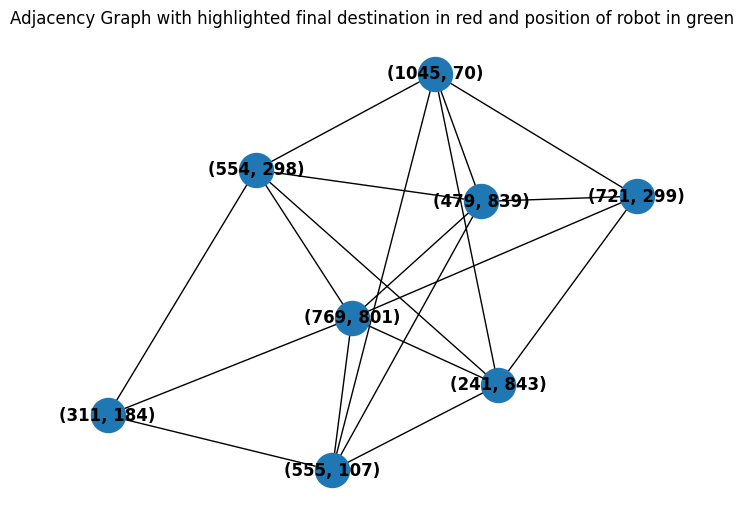

In [264]:
# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=600, font_weight='bold')
# Draw the highlighted vertex of position of robot and goal position  in a different color
#nx.draw_networkx_nodes(G, pos, nodelist=[(Xcent, Ycent)], node_size=600, node_color='red')
#nx.draw_networkx_nodes(G, pos, nodelist=[(Xrob_center, Yrob_center)], node_size=600, node_color='green')

plt.title('Adjacency Graph with highlighted final destination in red and position of robot in green')
plt.show()


In [256]:
# Calculate Euclidean distances between connected vertices
euclidean_distances = {}
for u, v in G.edges:
    # Extract coordinates of the vertices (u and v)
    x1, y1 = u
    x2, y2 = v

    # Calculate Euclidean distance between the vertices
    distance = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

    # Store the calculated Euclidean distance in the dictionary
    euclidean_distances[(u, v)] = distance

# Output the Euclidean distances
print(euclidean_distances)
print(len(euclidean_distances))

{}
0


## A* star algorithm to find global shortest Path
h(n) = euclidean distance to the goal node excluding obstacles

Sources: <br>
    <ol>
    <li>BOMR Exercise 5 solutions</li>
    <li>https://en.wikipedia.org/wiki/A*_search_algorithm#Pseudocode</li>
    </ol>

In [153]:
def reconstruct_path(cameFrom, current):
    complete_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        complete_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return complete_path

In [154]:
G.nodes

NodeView(((311, 184), (1045, 70), (1127, 552), (96, 113), (769, 801), (993, 691), (241, 843), (479, 839)))

In [187]:
print(list(G.neighbors((96, 113))))
gScore = dict(zip(G.nodes, [np.inf for x in range(len(G.nodes))]))
print(gScore)

print(euclidean_distances[((311, 184), (1045, 70))]) 

[(311, 184), (1045, 70), (241, 843)]
{(311, 184): inf, (1045, 70): inf, (1127, 552): inf, (96, 113): inf, (769, 801): inf, (993, 691): inf, (241, 843): inf, (479, 839): inf}
742.8001077005846


In [214]:
# start is the coordinates of start node
# goal is the coordinates of the goal node
# h is the heuristics of each node, the euclidean distance of each node to the goal
# node_distances is a dict of distance between nodes
# graph is adjacency graph defined as a networkx object

def AStar (start, goal, h, node_distances, graph):
    
    # set of visited nodes
    visitedSet = []
    
    # set of unvisited nodes
    unvisitedSet = [start]

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # set the gScore for all the nodes in the graph to infinity
    gScore = dict(zip(G.nodes, [np.inf for x in range(len(G.nodes))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(G.nodes, [np.inf for x in range(len(G.nodes))]))
    fScore[start] = h[start] 
    #print(h[start])
    
    # while there are still nodes to visit
    while len(unvisitedSet)!=0:
        #find the unvisited node having the lowest fScore[] value
        
        lowestFScoreSet = {}
        for node in unvisitedSet:
            lowestFScoreSet[node] = fScore[node]
        curr_node = min(lowestFScoreSet, key=lowestFScoreSet.get)
        
        #If the goal is reached, reconstruct and return the obtained path
        if curr_node == goal:
            # adding the goal coordinate to visited dict
            # returning the cost to get to goal and path to get to goal
            return reconstruct_path(cameFrom, curr_node)
        
        #print(curr_node)
        #print(unvisitedSet)
        unvisitedSet.remove(curr_node)
        visitedSet.append(curr_node)        
        
        neighborset = G.neighbors(curr_node)
        #print(neighborset)
        
        # If the goal was not reached, for each neighbor of current:
        for neighbor in neighborset:
             
            # if the node is occupied or has already been visited, skip
            if (neighbor in visitedSet):
                continue 

            # print(neighbor)
            # print(curr_node)
            # compute the cost to reach the node through the given path
            try:
                distance_to_neighbor = node_distances[(curr_node, neighbor)] 
            except:
                distance_to_neighbor = node_distances[(neighbor, curr_node)] 

            tentative_gScore = gScore[curr_node] + distance_to_neighbor

            # Add the neighbor list of nodes who's neighbors need to be visited
            if neighbor not in unvisitedSet:
                unvisitedSet.append(neighbor)

            # If the computed cost is the best one for that node, then update the costs and 
            # node from which it came
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = curr_node
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = tentative_gScore + h[neighbor]
                
        print(len(unvisitedSet))

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return start

In [215]:
start = (Xrob_center, Yrob_center)
print(start)
goal = (Xcent, Ycent)
print(goal)
distances = euclidean_distances
heuristic = {}
for node in G.nodes:
    x, y = node
    distance = ((goal[0] - x) ** 2 + (goal[1] - y) ** 2) ** 0.5
    heuristic[node] = distance   

path = AStar(start, goal, heuristic, euclidean_distances, G)
print(path)
# TODO
# 2. update the recomputation of costs 
# 3. Create new graph with highlighted route

(96, 113)
(1127, 552)
1
neighbor
(311, 184)
Appending
neighbor
(1045, 70)
Appending
neighbor
(241, 843)
Appending
3
3
neighbor
(1045, 70)
neighbor
(769, 801)
Appending
neighbor
(241, 843)
neighbor
(479, 839)
Appending
4
4
neighbor
(479, 839)
neighbor
(1045, 70)
neighbor
(993, 691)
Appending
4
4
neighbor
(1127, 552)
Appending
neighbor
(1045, 70)
4
4
[(96, 113), (311, 184), (769, 801), (993, 691), (1127, 552)]


## Updating Adjacency Graph with Optimal Path

[(96, 113), (311, 184), (769, 801), (993, 691), (1127, 552)]


IndexError: list index out of range

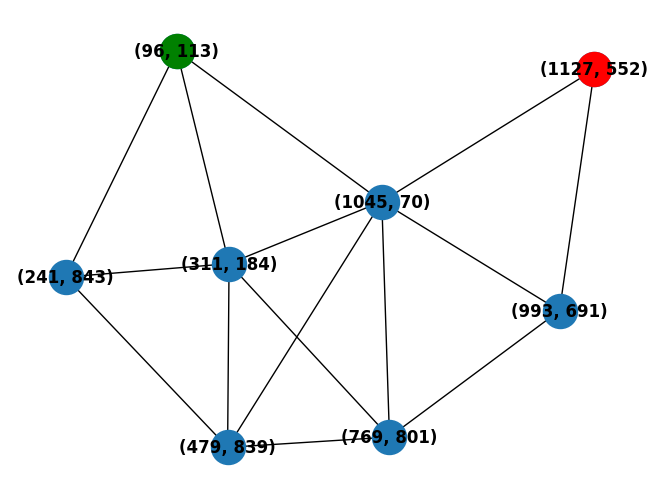

In [267]:
# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=600, font_weight='bold')
# Draw the highlighted vertex of position of robot and goal position  in a different color
nx.draw_networkx_nodes(G, pos, nodelist=[(Xcent, Ycent)], node_size=600, node_color='red')
nx.draw_networkx_nodes(G, pos, nodelist=[(Xrob_center, Yrob_center)], node_size=600, node_color='green')

# draw optimal path
edgelist = []
print(path)

for i, (a, b) in enumerate(path):
    edgelist.append((path[i], path[i + 1]))

# for i in range(len(path) - 1):
#     print(path[i])
#     edgelist.append((path[i], path[i + 1]))
    


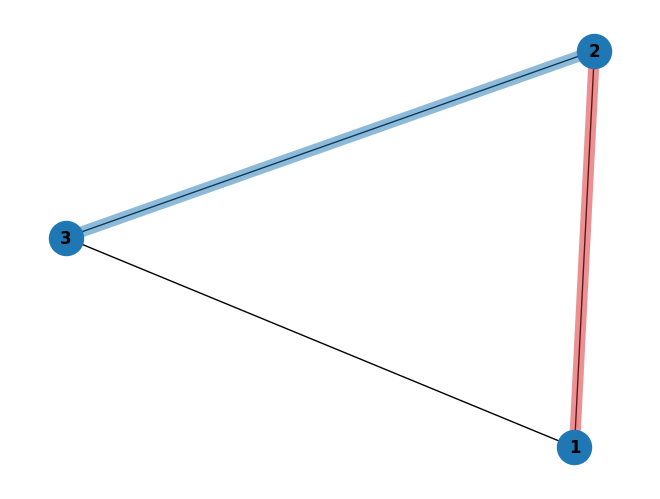

In [242]:
G2 = nx.Graph([(1, 2), (2,3), (1,3)])
pos2 = nx.spring_layout(G2)
G2[1][2]['weight'] = 100
G2[2][3]['weight'] = 4.7
G2[1][3]['weight'] = 4.7
# edges
nx.draw(G2, pos2, with_labels=True, node_size=600, font_weight='bold')
nx.draw_networkx_edges(
    G2,
    pos2,
    edgelist=[(1, 2)],
    width=8,
    alpha=0.5,
    edge_color="tab:red",
)
nx.draw_networkx_edges(
    G2,
    pos2,
    edgelist=[(2, 3)],
    width=8,
    alpha=0.5,
    edge_color="tab:blue",
)



## Changing path to account for thickness of Thymio